<span style="font-size:18px; color:red; font-weight:bold">Churn Bancario, construyendo un modelo de Machine Learning en Python</span>

**Enrique Aranaz Tudela**

LInkedin: www.linkedin.com/in/enrique-aranaz-tudela

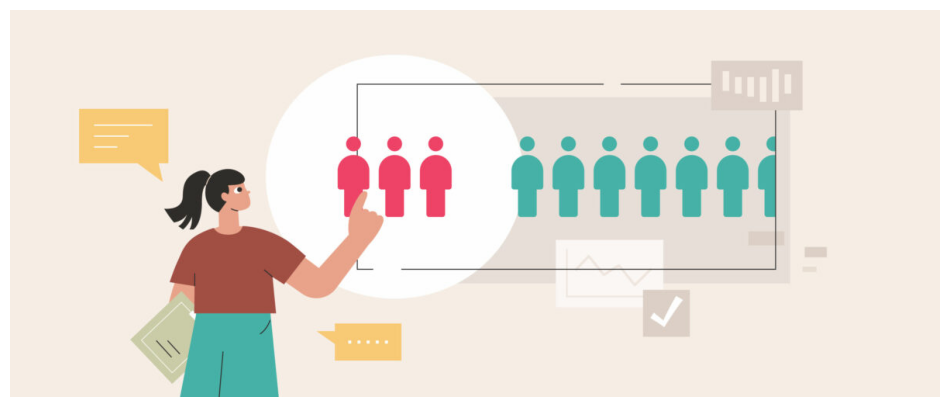

In [26]:
mostrar_imagen('c:/Phyton/Churn.jpeg')

<span style="font-size:24px; color:red; font-weight:bold">Indice</span>

<span style="font-size:18px; color:red; font-weight:bold">0. Importación de librerias a utilizar y definición de funciones</span>

<span style="font-size:18px; color:red; font-weight:bold">1. Definición del problema</span>

    1.1 Introducción al problema que queremos abordar
    1.2 Descripción del dataset y sus variables

<span style="font-size:18px; color:red; font-weight:bold">2. Preparación de los datos</span>

    2.1 Importación de librerias a utilizar
    2.2 Carga del dataset y descripción de los datos
    2.3 Data Cleaning 

        2.3.1 Identificación valores nulos, duplicados, valores no utiles para el modelo o con poca varianza
        2.3.2 Analisis descriptivo univariante y bivariante
        2.3.3 Identificación de valores atípicos y definición de estrategias con ellos
        2.3.4 Data Transforms: Cambiando la escala o distribución de las variables

    2.4 Feature Selection: Identificación de las variables más relevantes

        2.4.1 Filter Methods: Correlación, Chi-cuadrado y Anova
        2.4.2 Filter Methods empleando el metodo K-best
        2.4.3 Embedded Methods: RandomForest

        2.4.4 Conclusiones Feature Selection

    2.5 Reducción de la dimensionalidad de los datos
    2.6 Feature engineering: Creación de nuevas variables

<span style="font-size:18px; color:red; font-weight:bold">3. Entrenamiento y evaluación de modelos</span>

    3.1 Elección de algoritmos de machine learning adecuados para el problema.
    3.2 Aplicación de RamdonOverSampler para corregir problema de desequilibrio. 
    3.3 Entrenamiento de los modelos y evaluación de su rendimiento. 
    3.4 Selección de los dos mejores modelos y optimización (ajuste hiperparámetros).

<span style="font-size:18px; color:red; font-weight:bold">4. Modelo final</span>

    4.1 Añadir las probabilidades obtenidas por el modelo al dataset
    4.2 Segmentación de nuestra cartera de clientes y descripción de cada segmento en función de las características más relevantes

<span style="font-size:18px; color:red; font-weight:bold">5. Conclusiones y recomendaciones</span>


<span style="font-size:24px; color:red; font-weight:bold">0. Importación de librerias a utilizar y definición de funciones</span>

In [1]:
# Librerias básicas:
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pylab
import matplotlib.ticker as mtick
import matplotlib.image as mpimg
from scipy.stats import shapiro, normaltest, kstest, jarque_bera
from scipy.stats import probplot
from scipy.stats import stats
from scipy.stats import mstats

# Feature Selection, Preprocesado, Modelos, Métricas, GridSearch:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegressionCV 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score,f1_score,accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_digits

from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import Precision, Recall

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Funciones vamos a utilizar

def plot_vector_charts(vector_cols, titulo):
    # Definir una paleta de colores personalizada
    color_palette = ["#800000", "#8000ff", "#6aac90", "#5833ff", "#da8829"]
    color_pastel = ["#53D021", "#EB2325"]
    bar_palette = {0: 'blue', 1: 'red'}
    colors = ["#53D021", '#EB2325']
    
    # Configurar la figura con constrained_layout
    fig, axes = plt.subplots(len(vector_cols), 2, figsize=(16, 8))  # Aumentar el ancho de la figura
    fig.patch.set_facecolor("#ffe6e6")

    # Título del gráfico
    fig.suptitle(titulo, fontsize=10, fontweight='bold', fontfamily='serif', color="#000000")

    # Crear gráficos de pastel y de barras para cada columna categórica
    for i, col in enumerate(vector_cols):
        # Gráfico de pastel
        pie_ax = axes[i, 0]
        (df[col].value_counts() * 100.0 / len(df)).plot.pie(
            autopct=lambda p: f'{p:.1f}%', fontsize=8, ax=pie_ax, colors=color_palette, textprops={'color': 'black'})
        pie_ax.set_ylabel('')
        pie_ax.set_title(col, fontsize=8, backgroundcolor='skyblue')

        # Agrupar datos por la columna actual y estado de salida
        churn_data = df.groupby([col, 'Exited']).size().unstack()

        # Crear gráfico de barras apiladas
        bar_ax = axes[i, 1]
        ax = churn_data.plot(kind='bar', stacked=True, color=colors, rot=0, ax=bar_ax)
        ax.legend(labels=['Stayed', 'Churned'], fontsize=8)  # Tamaño de la leyenda reducido
        ax.set_title(f'{col} Distribution and Churn rate', fontsize=8)  # Tamaño del título reducido
        ax.set_ylabel('Customer Count')

        # Añadir anotaciones de porcentaje
        for p in ax.patches:
            w, h = p.get_width(), p.get_height()
            x, y = p.get_xy()
            if x == -0.25:
                col_sum = churn_data.T.sum().iloc[0]
            else:
                col_sum = churn_data.T.sum().iloc[1]

            temp = np.array(round(h * 100 / col_sum, 1))  # Redondear a un decimal
            anot = str(temp)
            ax.annotate(anot + '%', (x + 0.15, y + h / 2), color='white', weight='bold', size=8)  # Tamaño de fuente reducido

        # Añadir líneas discontinuas al eje y
        ax.grid(color='#000000', linestyle=':', axis='y', zorder=0, dashes=(1, 5))

    # Ajustar manualmente el diseño para aumentar el espacio vertical entre gráficos
    plt.subplots_adjust(hspace=0.6, wspace=0.2)  # Reducir el espacio horizontal entre subplots
    plt.show()

def mostrar_imagen(ruta_imagen):
    img = mpimg.imread(ruta_imagen)
    plt.figure(figsize=(12, 10))
    imgplot = plt.imshow(img)
    plt.axis('off')  # Desactivar los ejes
    plt.show()

def plot_chart(titulo):

    # Configurar la figura
    fig, ax = plt.subplots(figsize=(8, 4))
    background_color = "#ffe6e6"
    fig.patch.set_facecolor(background_color)
    ax.set_facecolor(background_color)

    # Crear el gráfico de barras horizontal
    sns.barplot(x='f1_score', y='Modelo', hue='Modelo', data=Model_com_df, ax=ax, palette='viridis', legend=False)

    # Añadir etiquetas y título
    ax.set_title(titulo, fontsize=10, fontweight='bold')
    ax.set_xlabel('f1_score', fontsize=12)
    ax.set_ylabel('Modelo', fontsize=12)

    # Añadir valores de f1_score a las barras con un decimal
    for p in ax.patches:
        width = p.get_width()
        ax.annotate(f'{width:.2f}', xy=(width, p.get_y() + p.get_height() / 2),
                xytext=(3, 0), textcoords="offset points", fontsize=8, fontweight='bold')

    # Mostrar el gráfico
    plt.show()

def evaluationModel(y_test, y_pred):
    # Calcular la matriz de confusión
    cn = confusion_matrix(y_test, y_pred)
    
    # Calcular el porcentaje de cada celda sobre el total de la fila
    cn_percent = cn / cn.sum(axis=1, keepdims=True) * 100
    
    # Nombres personalizados para las celdas
    names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    
    # Crear anotaciones combinadas de nombres, números absolutos y porcentajes
    combined_labels = np.array([f'{name}\n{value}\n{percent:.2f}%' for name, value, percent in zip(names, cn.flatten(), cn_percent.flatten())]).reshape(2, 2)
    
    # Crear el heatmap
    sns.heatmap(cn, annot=combined_labels, fmt='', cmap='Blues', cbar=False, xticklabels=['Predicted No Churn', 'Predicted Churn'], yticklabels=['Actual No Churn', 'Actual Churn'])
    
    # Añadir etiquetas y título
    plt.xlabel('Predicted Label')  
    plt.ylabel('True Label')  
    plt.title('Confusion Matrix') 
    plt.show()

<span style="font-size:24px; color:red; font-weight:bold">Epigrafes 1 y 2 en ChurnBanksEDA(Parte1) y 3,4 y 5 en ChurnBanksModelos(Parte2).ipynb</span>

<span style="font-size:24px; color:red; font-weight:bold">6. Deep Learning: Creación de un Multilayer Perceptron (MLP)</span>

A continuación aplicare un modelo de Deep Learning, en concreto construiremos un **Multilayer Perceptron (MLP)**, que es un tipo de red neuronal artificial que se utiliza comúnmente para problemas de clasificación y regresión. En el contexto de un modelo de churn bancario, un MLP puede ayudar a predecir si un cliente abandonará el banco basándose en diversas características.

Los resultados del MLP serán comparados con los modelos de Machine Learning que desarrollamos anteriormente (Ver ChurnBanksModelos(Parte2)).

In [144]:
# Importamos Dataset ya trabajado con EDA
df=pd.read_csv('c:/Phyton/Customer-Churn-RecordsEDA.csv')
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Satisfaction_Score,Point_Earned,Geography_Germany,Geography_Spain,Card_Type_GOLD,Card_Type_PLATINUM,Card_Type_SILVER
0,619,0,42,2,0.00,1,1,1,101348.88,1,2,464,False,False,False,False,False
1,608,0,41,1,83807.86,1,0,1,112542.58,0,3,456,False,True,False,False,False
2,502,0,42,8,159660.80,3,1,0,113931.57,1,3,377,False,False,False,False,False
3,699,0,39,1,0.00,2,0,0,93826.63,0,5,350,False,False,True,False,False
4,850,0,43,2,125510.82,1,1,1,79084.10,0,5,425,False,True,True,False,False


In [146]:
# Importamos resultados de los modelos anteriores para compararlos
df_Resultados=pd.read_csv('c:/Phyton/ResultadosModelos.csv')

In [148]:
# definimos funciones vamos a utilizar
import itertools

def metricas_matriz(y_test, y_pred):
    # Calcular la matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Normalizar la matriz de confusión por filas (por el verdadero valor)
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    # Dibujar la matriz de confusión
    plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(y_test)))
    plt.xticks(tick_marks, np.unique(y_test))
    plt.yticks(tick_marks, np.unique(y_test))

    # Añadir etiquetas a las celdas con porcentajes sobre la fila
    fmt = '.2f'
    thresh = conf_matrix_normalized.max() / 2.
    for i, j in itertools.product(range(conf_matrix_normalized.shape[0]), range(conf_matrix_normalized.shape[1])):
        plt.text(j, i, f'{conf_matrix[i, j]} ({conf_matrix_normalized[i, j] * 100:.2f}%)',
                 horizontalalignment="center",
                 color="white" if conf_matrix_normalized[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred, average='binary') * 100
    recall = recall_score(y_test, y_pred, average='binary') * 100
    f1 = f1_score(y_test, y_pred, average='binary') * 100

    print(f"Model Accuracy: {accuracy:.2f}%")
    print(f"Model Precision: {precision:.2f}%")
    print(f"Model Recall: {recall:.2f}%")
    print(f"Model F1-Score: {f1:.2f}%")

    # añadir resultados de MLP a los de los modelos de ML
    num = len(df_Resultados)
    df_Resultados.loc[num] = ['Multilayer Perceptron (MLP) (Oversamp.)', 'OverSamp', accuracy/100, recall/100, f1/100, precision/100]
    
    #Reporte de clasificación
    print(classification_report(y_pred, y_test, zero_division=1))

    # Calcular precisiones por clase
    accuracy_class_0 = accuracy_score(y_pred[y_test == 0], y_test[y_test == 0])
    accuracy_class_1 = accuracy_score(y_pred[y_test == 1], y_test[y_test == 1])

    print(f"Accuracy for class 0: {accuracy_class_0:.2f}")
    print(f"Accuracy for class 1: {accuracy_class_1:.2f}")

Entrenaremos nuestro MLP aplicando RandomOverSampler al conjunto de entrenamiento pues hemos visto que funciona mejor

In [151]:
# Ya le hemos hecho one hot encoding a los datos al construir los modelos de ML

# Separar características y etiquetas
X = df.drop('Exited', axis=1).values
y = df['Exited'].values

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

# Aplicar RandomOverSampler solo al conjunto de entrenamiento
rand_over_samp = RandomOverSampler(random_state=42)
X_train, y_train = rand_over_samp.fit_resample(X_train, y_train)

# Normalizar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Imprimir los conjuntos de datos
print("X_train:\n", X_train.shape)
print("X_test:\n", X_test.shape)
print("y_train:\n", y_train.shape)
print("y_test:\n", y_test.shape) 

X_train:
 (12772, 16)
X_test:
 (2000, 16)
y_train:
 (12772,)
y_test:
 (2000,)


In [153]:
print("X_train:\n", X_train)
print("y_train:\n", y_test)

X_train:
 [[-0.44671287  0.98987276 -0.00345844 ...  1.79503447 -0.58000227
  -0.57855572]
 [ 0.39290626 -1.01023085 -0.09784132 ... -0.55709237 -0.58000227
  -0.57855572]
 [-0.06786033 -1.01023085  1.31790185 ... -0.55709237  1.72413117
  -0.57855572]
 ...
 [ 0.81271582 -1.01023085  1.69543337 ...  1.79503447 -0.58000227
  -0.57855572]
 [ 1.19156835  0.98987276  0.18530732 ...  1.79503447 -0.58000227
  -0.57855572]
 [-1.08154684  0.98987276  0.65722171 ... -0.55709237 -0.58000227
  -0.57855572]]
y_train:
 [0 0 1 ... 0 0 1]


A continuación Construiremos el modelo Perceptron multicapa (Multilayer Perceptron, MLP):

In [155]:
numero_entradas= X_train.shape[1]

# Construcción del modelo Perceptron multicapa (Multilayer Perceptron, MLP)

model = Sequential() #(1)
model.add(Dense(64, input_dim=numero_entradas, activation='relu')) #(2)
model.add(Dense(32, activation='relu')) 
model.add(Dense(1, activation='sigmoid')) #(3)

#(1) Esta línea crea un modelo secuencial en Keras. Un modelo secuencial es una pila lineal de capas, donde cada capa tiene exactamente una
#entrada y una salida. Es ideal para modelos simples donde las capas se apilan una tras otra

#(2) Añade otra capa densa con 32 neuronas y la misma función de activación ReLU. Esta capa toma la salida de la capa anterior como su
# entrada y añade una capa densa (fully connected) al modelo. Dense(64): Crea una capa con 64 neuronas. #input_dim=numero entradas:
# Especifica el número de entradas (características) que la capa espera. Este valor debe coincidir con el
# número de características en tus datos de entrada. activation=‘relu’: Usa la función de activación ReLU (Rectified Linear Unit), 
# que es comúnmente utilizada en redes neuronales porque ayuda a manejar el problema del desvanecimiento del gradiente

#(3) Añade la capa de salida con una sola neurona: Dense(1): Crea una capa con 1 neurona, lo cual es adecuado para problemas de clasificación binaria (como predecir si un cliente hará
#churn o no).activation=‘sigmoid’: Usa la función de activación sigmoide, que es ideal para problemas de clasificación binaria
#porque convierte la salida en un valor entre 0 y 1, interpretado como una probabilidad.

#Resumen del Modelo
#Modelo Secuencial: Una pila lineal de capas.
#Primera Capa: 64 neuronas, función de activación ReLU, recibe las entradas del modelo.
#Segunda Capa: 32 neuronas, función de activación ReLU.
#Capa de Salida: 1 neurona, función de activación sigmoide, produce la probabilidad de churn.
#Este modelo es bastante básico y puede ser un buen punto de partida. Se puede experimentar añadiendo más capas, 
#cambiando el número de neuronas, o probando diferentes funciones de activación para mejorar el rendimiento.

# Compilar el modelo

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

# Si quisieramos Ajustar los pesos de las clases
#class_weight = {0: 0.8, 1: 0.2}
#history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_data=(X_test, y_test), class_weight=class_weight)

# Entrenar el modelo
history= model.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test))

Epoch 1/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6821 - loss: 0.5776 - precision: 0.6841 - recall: 0.6749 - val_accuracy: 0.7755 - val_loss: 0.4801 - val_precision: 0.4818 - val_recall: 0.7783
Epoch 2/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 1s 989us/step - accuracy: 0.7687 - loss: 0.4730 - precision: 0.7783 - recall: 0.7477 - val_accuracy: 0.8025 - val_loss: 0.4280 - val_precision: 0.5244 - val_recall: 0.7358
Epoch 3/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 1s 989us/step - accuracy: 0.7913 - loss: 0.4408 - precision: 0.7951 - recall: 0.7799 - val_accuracy: 0.7990 - val_loss: 0.4384 - val_precision: 0.5183 - val_recall: 0.7335
Epoch 4/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7986 - loss: 0.4304 - precision: 0.8073 - recall: 0.7779 - val_accuracy: 0.7990 - val_loss: 0.4354 - val_precision: 0.5179 - val_recall: 0.7500
Epoch 5/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 1s 995us/step - accuracy: 0.8083 - loss: 0.4086 - precision: 0.8155 - recall: 0.7935 - val_accuracy: 0.783

In [ ]:
Evaluación de su rendimiento:

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


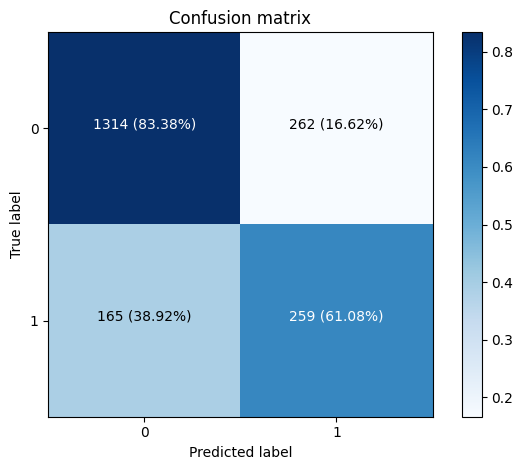

Model Accuracy: 78.65%
Model Precision: 49.71%
Model Recall: 61.08%
Model F1-Score: 54.81%
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1479
           1       0.61      0.50      0.55       521

    accuracy                           0.79      2000
   macro avg       0.72      0.69      0.70      2000
weighted avg       0.78      0.79      0.78      2000

Accuracy for class 0: 0.83
Accuracy for class 1: 0.61


In [157]:
# Predicciones
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba >= 0.5).astype(int)

metricas_matriz(y_test, y_pred)

A continuación dibujaremos curvas de aprendizaje para la precisión y la pérdida tanto en el conjunto de entrenamiento 
como en el de validación. Esto ayuda a identificar si el modelo está sobreajustando o subajustando.

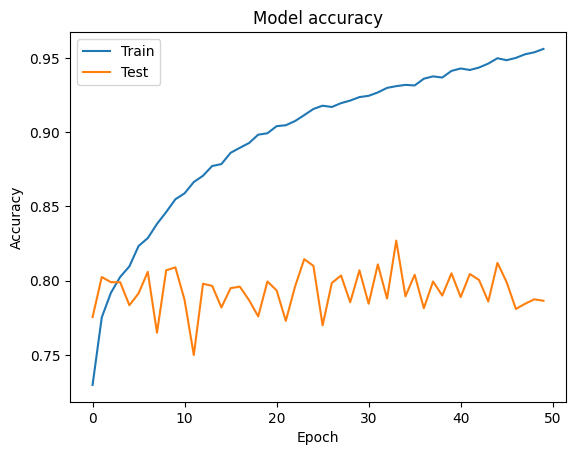

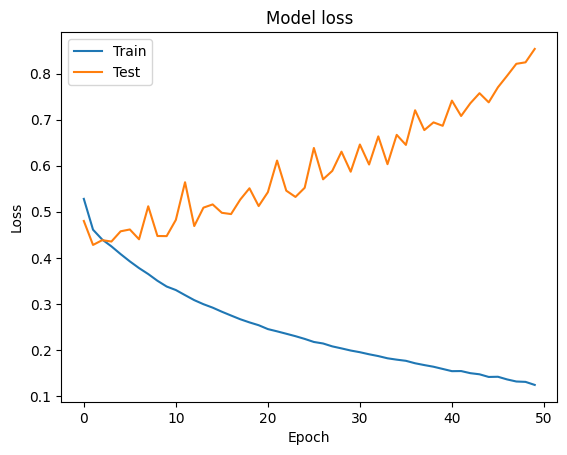

In [159]:
#Curvas de Aprendizaje

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Cómo podemos ver en la curca del Accuracy, el modelo tiene cierto sobreajuste, mejorando a medida que avanzan las epocas significativamente el rendimiento de la muestra de entrenamiento mientras la de test se mantiene estable en torno a un 0,80 de Accuracy.

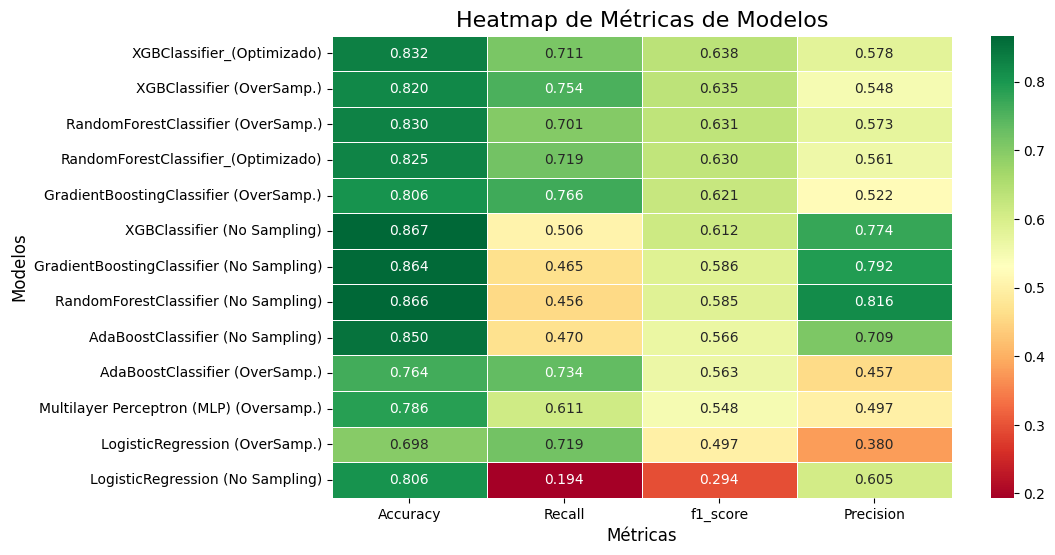

In [161]:
# Comparamos el MLP con los resultados de los otros modelos de ML

# Crear el heatmap sin incluir la columna 'Sampling'
plt.figure(figsize=(10, 6))
heatmap_data = df_Resultados.set_index('Modelo').drop(columns=['Sampling']).sort_values(by='f1_score', ascending=False)
sns.heatmap(heatmap_data, annot=True, cmap='RdYlGn', linewidths=.5, fmt='.3f')

# Configurar el título y las etiquetas
plt.title('Heatmap de Métricas de Modelos', fontsize=16)
plt.xlabel('Métricas', fontsize=12)
plt.ylabel('Modelos', fontsize=12)
plt.show()

Vemos que el MLP esta muy lejos de mejorar los rendimientos de los modelos de ML que hemos desarrollado anteriormente. Para ver si podemos mejorar el f1_score, buscaremos el therholds (probabilidad de corte para establecer Exited=1, esto es, cliente que abandona, que es por defecto 0,5).

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step


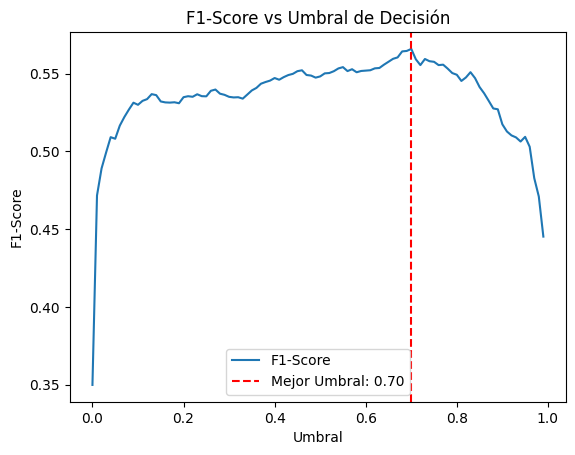

Mejor Umbral: 0.70
Mejor F1-Score: 0.57


In [163]:
#Ajuste del umbral de decisión: En lugar de usar un umbral de 0.5 para clasificar, 
#ajusta el umbral para encontrar un mejor equilibrio entre precisión y recall.

#calculamos el mejor umbral de decisión y el F1-Score correspondiente,
#además de generar un gráfico para visualizarlo:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Obtener las predicciones del modelo
y_pred = model.predict(X_test)

# Definir una función para calcular el F1-Score para diferentes umbrales
def calculate_f1_scores(y_test, y_pred):
    thresholds = np.arange(0.0, 1.0, 0.01)
    f1_scores = []
    for threshold in thresholds:
        y_pred_classes = (y_pred > threshold).astype("int32")
        f1 = f1_score(y_test, y_pred_classes)
        f1_scores.append(f1)
    return thresholds, f1_scores

# Calcular los F1-Scores para diferentes umbrales
thresholds, f1_scores = calculate_f1_scores(y_test, y_pred)

# Encontrar el mejor umbral y el F1-Score correspondiente
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1_score = max(f1_scores)

# Generar el gráfico
plt.plot(thresholds, f1_scores, label='F1-Score')
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Mejor Umbral: {best_threshold:.2f}')
plt.xlabel('Umbral')
plt.ylabel('F1-Score')
plt.title('F1-Score vs Umbral de Decisión')
plt.legend()
plt.show()

print(f'Mejor Umbral: {best_threshold:.2f}')
print(f'Mejor F1-Score: {best_f1_score:.2f}')


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step


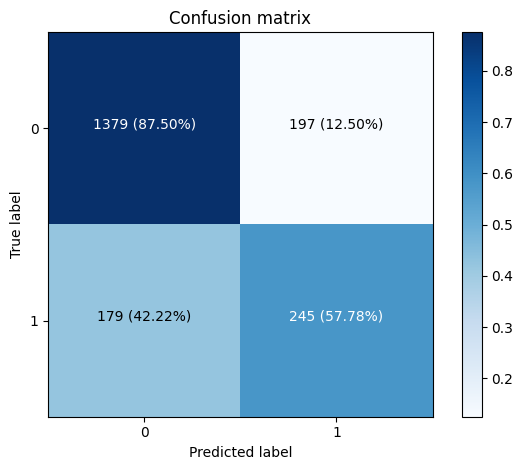

Model Accuracy: 81.20%
Model Precision: 55.43%
Model Recall: 57.78%
Model F1-Score: 56.58%
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      1558
           1       0.58      0.55      0.57       442

    accuracy                           0.81      2000
   macro avg       0.73      0.72      0.72      2000
weighted avg       0.81      0.81      0.81      2000

Accuracy for class 0: 0.88
Accuracy for class 1: 0.58


In [165]:
import itertools

# Obtener las predicciones del modelo
y_pred = model.predict(X_test)
# Ajustar el umbral de decisión
threshold = best_threshold
y_pred_classes = (y_pred > threshold).astype("int32")

metricas_matriz(y_test, y_pred_classes)